<a href="https://colab.research.google.com/github/beccalunch/adv-ml-playground/blob/main/gradient-attacks/deepfool/deepfool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# DeepFool
DeepFool, similar to FGSM, is a linear perturbation method of generating adversarial noise that will cause a classifier to make an inaccurate prediction. It is written about in [this 2016 paper](https://arxiv.org/pdf/1511.04599.pdf).

The main difference between DeepFool and FGSM, according to the authors, is in the robustness that DeepFool offers when training models using adversarial examples. They prove that DeepFool, when compared to FGSM, more reliably and efficiently generates adversarial examples.

Rather than following a tutorial for this one, I'll be attempting my own implementation in Tensorflow. Like the FGSM example implemented, I'll use the MobileNetV2 model pre-trained on ImageNet.





In [1]:
import copy
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.grid'] = False


In [2]:

pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                     weights='imagenet')
pretrained_model.trainable = False

decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 0s 0us/step


In [21]:
type(pretrained_model)

keras.src.engine.functional.Functional

In [3]:
# function to preprocess the image for MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

# extract labels from the probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]


## Original Image
Like the FGSM example, I'll be using a stop sign image in a bit of weather:

![](https://county17.com/wp-content/uploads/2022/03/Westover-3292022.jpg)

In [4]:
image_path = tf.keras.utils.get_file('stopsign.jpg', 'https://county17.com/wp-content/uploads/2022/03/Westover-3292022.jpg')#'https://pbs.twimg.com/media/GIAIPm-X0AAZ4I0?format=jpg&name=large')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 1s 1s/step


35363/35363 [==============================] - 0s 0us/step


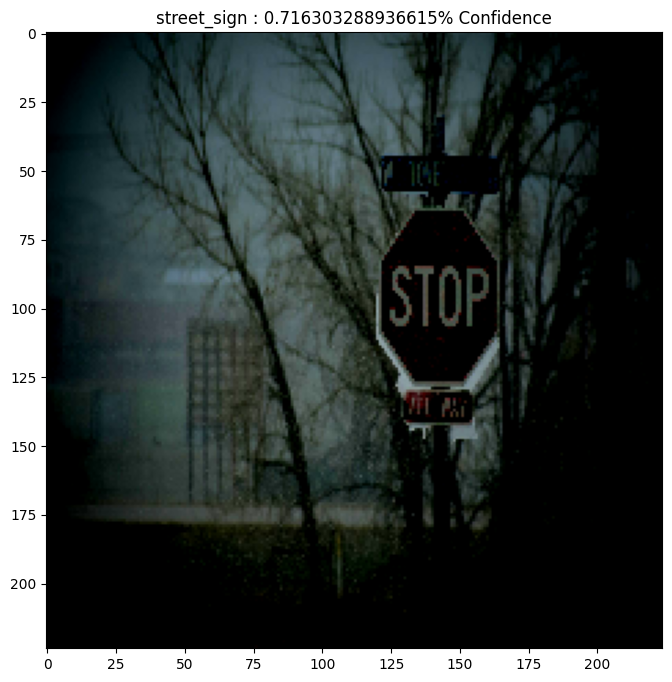

In [5]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title(f'{image_class} : {class_confidence}% Confidence')
plt.show()

## Generating the adversarial perturbation
 They first outline in the binary case, in which it is described as being "a gradient descent algorithm with an adaptive step size that is automatically chosen at each iteration".

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*_MtlgwK7XbPTr_MV.png)

Shown here for the binary case, the idea is to generate a perturbation $r^*(x)$ such that, when applied to input $x$, the result is projected onto the decision boundary of the binary classifier. This is done until the classification changes. An overshoot parameter $\eta$ is used in the multiplier $(1 + \eta)$ to the perturbation $r^*(x)$ to cause it to go past the decision boundary.

This binary algorithm is shown below

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*s8gWPvxIzW8bPhph.png)

This is extended to a multiclass example. Rather than a single decision boundary, we instead consider a decision "polyhedron". The minimum perturbation needs to be computed, which would be closest hyperplane to $x_0$ in the visual shown below.

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*7_JadYZXz_pHVelm.png)


Since there are multiple classes, the loss and backpropagation need to be computed for each class allowed by the function.

![](https://miro.medium.com/v2/resize:fit:1400/1*IgCRmdFMEMt8vyGzxMsq9A.png)

The algorithm is shown above.

Let's try it?

In [6]:
# Read in all of the possible imagenet classes
path = '/content/sample_data/imagenet_classes.txt'
with open(path, 'r') as f:
  lines = f.readlines()
classes = [s.strip('\n').replace(' ', '_') for s in lines]
classes[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

In [107]:
def show_image_and_pred(image, f):
  plt.figure()
  plt.imshow(image[0])
  _, image_class, class_confidence = get_imagenet_label(f)
  plt.title(f'{image_class} : {class_confidence}% Confidence')
  plt.show()


def deepfool(image, model, num_classes, loss_func, epsilon=0.002, max_iter=100):
  f_image = model.predict(image)
  show_image_and_pred(image, f_image)


  f_image = f_image.flatten() # numpy array len num_classes with class confidences

  # This gets the indices of the logit values in descending order, aka the classes from most to least likely
  I = (np.array(f_image)).flatten().argsort()[::-1]
  I = I[0:num_classes] # maybe we don't want 1000 classes, just the 10 most likely

  k0 = I[0]
  ki = k0

  # Keep track of perturbations
  r = []
  i = 1

  pert_tot = np.zeros(image.cpu().numpy().shape)

  # initialize the image to be manipulated
  image = tf.convert_to_tensor(image, dtype=tf.float32)
  x = copy.deepcopy(image)


  while ki == k0 and i < max_iter:
    print(i)
    # set pert to be infinity, so the first iteration will be saved
    pert = np.inf

    # first, compute the score and gradient wrt the original image class
    with tf.GradientTape() as tape:
      tape.watch(x)
      f = model(x, training=False)
      fk0 = f[0, I[0]]

      # compute gradient wrt image
      grad_0 = tape.gradient(fk0, x)

    # now iterate through the classes
    for k in range(1, num_classes):
      # compute the score and gradient wrt the potential class
      with tf.GradientTape() as tape:
        tape.watch(x)
        f = model(x, training=False)
        fki = f[0, I[k]]

        grad_k = tape.gradient(fki, x)

      # compute w' and f'
      w_k = grad_k - grad_0
      f_k = fki - fk0

      pert_k = abs(f_k) / np.linalg.norm(w_k)

      # check if it's better than the current minimum candidate
      if pert_k < pert:
        pert = pert_k
        w = w_k


    # now compute pert_i and update pert_tot
    pert_i = w * pert

    pert_tot = np.float32(pert_tot + pert_i)

    pert_image = image.numpy() + (1 + epsilon) * pert_tot
    x = tf.convert_to_tensor(pert_image, dtype=tf.float32)

    # check the prediction of the new model to see if we can end the loop
    f = model.predict(x)
    show_image_and_pred(x, f)
    ki = np.argmax(f).flatten().argsort()[::-1]
    i += 1

1/1 [==============================] - 0s 55ms/step


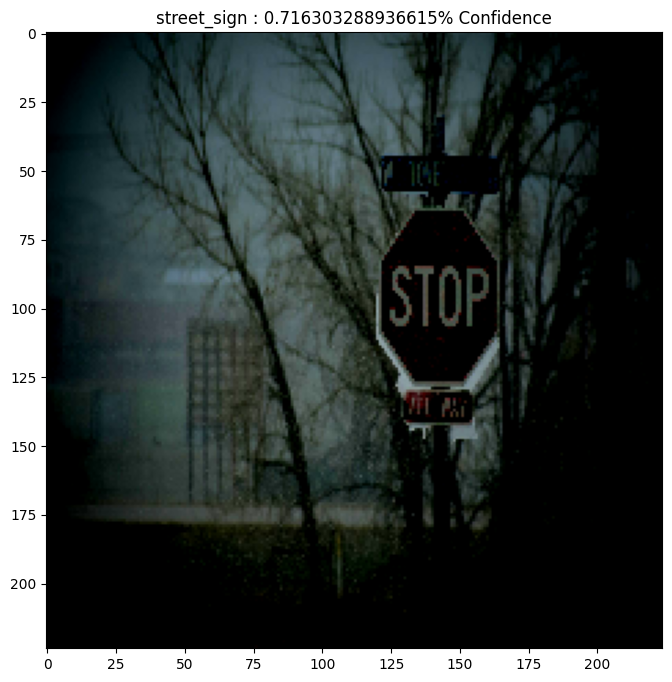

1
1/1 [==============================] - 0s 54ms/step


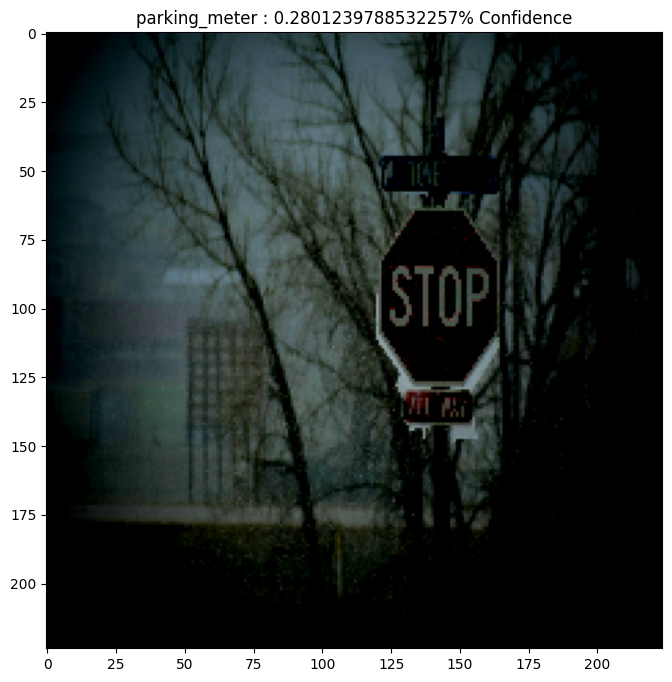

In [108]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
deepfool(image, pretrained_model, 10, loss_object)

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

In [ ]:
import torch

In [ ]:
torch.hub.load('https://github.com/pytorch/hub/blob/master/imagenet_classes.txt')

TypeError: load() missing 1 required positional argument: 'model'